### GenreBot : Using Natural Language Processing in Music Marketing

For background on this project, please see the [README](../README.md).

**Notebooks**
- [Data Acquisition](./01_data_acquisition.ipynb)
- [Data Cleaning](./02_data_cleaning.ipynb)
- Exploratory Data Analysis (this notebook)
- [Modeling](./04_modeling.ipynb)
- [Experiments](./04a_experiments.ipynb)
- [Results and Recommendations](./05_results.ipynb)

**In this notebook, you'll find:**
- Analysis and handling of null values in our raw posts dataset
- Regular expressions and other text transformations to make our columns more useful

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
df = pd.read_csv('../data/clean_posts.csv')

In [20]:
df.head()

,author,created_utc,id,num_comments,score,selftext,subreddit,title,period,all_text,all_text_len
0,discord,1221835135,72cy3,16,5,NaN,jazz,Anyone know of any dark / evil sounding jazz?,1,Anyone know of any dark evil sounding jazz,42
1,smacfarl,1222039404,72p6u,5,0,NaN,jazz,In honor of Soil &amp; Pimp showing us how it'...,1,In honor of Soil Pimp showing us how it's done...,114
2,[deleted],1223963408,76zmj,2,2,NaN,jazz,anybody have that record of Charlie Christian ...,1,anybody have that record of Charlie Christian ...,145
3,smacfarl,1224683862,78nrr,4,5,NaN,jazz,New Topline Image for Jazz subreddit. Suggesti...,1,New Topline Image for Jazz subreddit Suggestio...,73
4,ChefEspeff,1235783273,80wtq,10,2,NaN,jazz,"Teaching yourself Jazz Piano, is it possible?",1,Teaching yourself Jazz Piano is it possible,43


In [21]:
# let's also get a length-in-words column
df['all_text_word_len'] = df['all_text'].map(lambda x: len(x.split()))

In [22]:
df.head()

,author,created_utc,id,num_comments,score,selftext,subreddit,title,period,all_text,all_text_len,all_text_word_len
0,discord,1221835135,72cy3,16,5,NaN,jazz,Anyone know of any dark / evil sounding jazz?,1,Anyone know of any dark evil sounding jazz,42,8
1,smacfarl,1222039404,72p6u,5,0,NaN,jazz,In honor of Soil &amp; Pimp showing us how it'...,1,In honor of Soil Pimp showing us how it's done...,114,21
2,[deleted],1223963408,76zmj,2,2,NaN,jazz,anybody have that record of Charlie Christian ...,1,anybody have that record of Charlie Christian ...,145,26
3,smacfarl,1224683862,78nrr,4,5,NaN,jazz,New Topline Image for Jazz subreddit. Suggesti...,1,New Topline Image for Jazz subreddit Suggestio...,73,11
4,ChefEspeff,1235783273,80wtq,10,2,NaN,jazz,"Teaching yourself Jazz Piano, is it possible?",1,Teaching yourself Jazz Piano is it possible,43,7


In [23]:
# may as well check our baseline accuracy - should be pretty even though
df['subreddit'].value_counts(normalize = True)

# yep solid

classicalmusic    0.500426
jazz              0.499574
Name: subreddit, dtype: float64

In [24]:
# curiosity: unique users
len(df['author'].unique())

13874

In [25]:
# curiosity: unique users per subreddit
df.groupby('subreddit')['author'].nunique()

# wow pretty even - also interesting that they don't add up to the above
# which means there must be some crossover!

subreddit
classicalmusic    7069
jazz              7002
Name: author, dtype: int64

In [30]:
# how many crossovers?
classical_authors = set(df[df['subreddit'] == 'classicalmusic']['author'])
jazz_authors = set(df[df['subreddit'] == 'jazz']['author'])
len(jazz_authors.intersection(classical_authors))

197

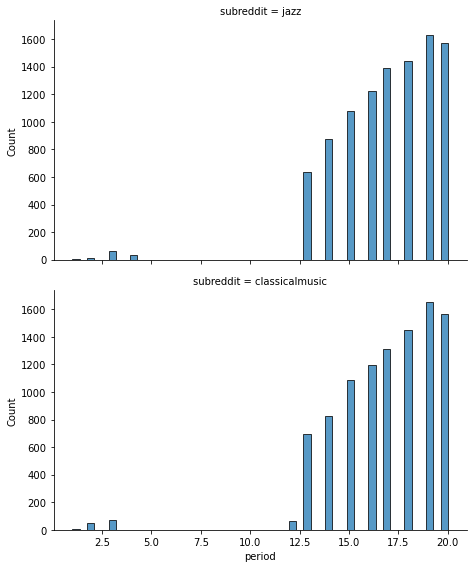

In [36]:
# how do the period histograms look?
# https://seaborn.pydata.org/tutorial/axis_grids.html for FacetGrid
g = sns.FacetGrid(df, row = 'subreddit', height = 4, aspect = 1.67)
g.map(sns.histplot, 'period');

# very similar - that gap in the middle is odd, but at least it's consistent

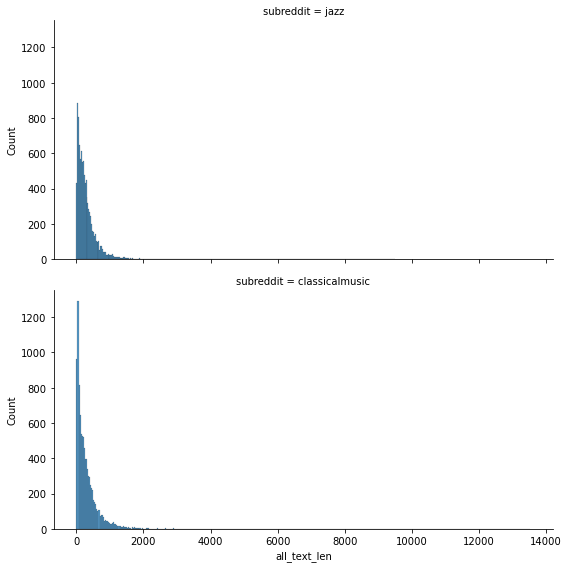

In [39]:
# how do the character length histograms look?
# https://seaborn.pydata.org/tutorial/axis_grids.html for FacetGrid
g = sns.FacetGrid(df, row = 'subreddit', height = 4, aspect = 2)
g.map(sns.histplot, 'all_text_len');

# we got some outliers for sure, otherwise not too different

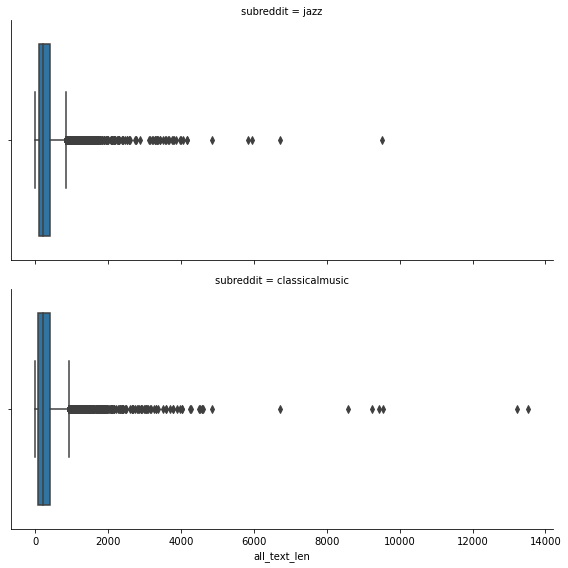

In [41]:
# how about those outliers?
g = sns.FacetGrid(df, row = 'subreddit', height = 4, aspect = 2)
g.map(sns.boxplot, 'all_text_len', order = 'all_text_len');

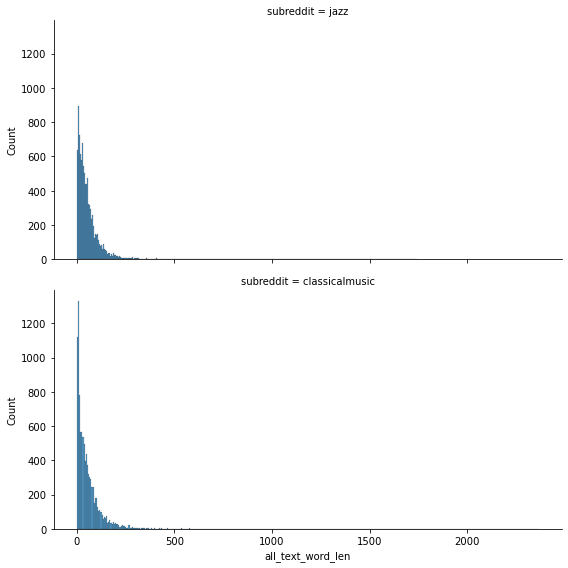

In [42]:
# how do the word length histograms look?
g = sns.FacetGrid(df, row = 'subreddit', height = 4, aspect = 2)
g.map(sns.histplot, 'all_text_word_len');

# we got some outliers for sure, otherwise not too different

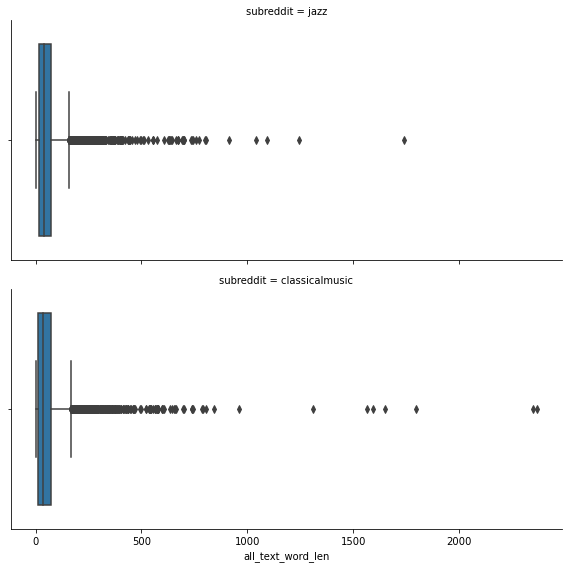

In [43]:
# how about those outliers?
g = sns.FacetGrid(df, row = 'subreddit', height = 4, aspect = 2)
g.map(sns.boxplot, 'all_text_word_len', order = 'all_text_word_len');

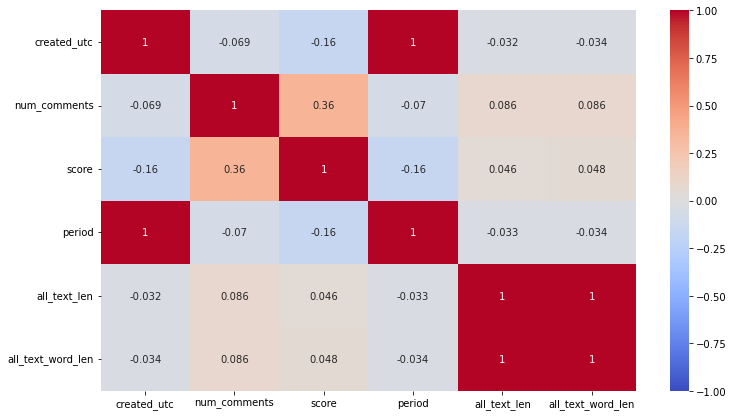

In [48]:
# let's see if there are any interesting correlations
plt.figure(figsize = (12, 7))
sns.heatmap(df.corr(), vmin = -1, vmax = 1, cmap = 'coolwarm', annot = True);

# unsurprising that the text lengths are exactly correlated, and the period and created_utc are correlated
# I was expecting there to be more comments on longer posts, but I guess not!

In [49]:
# let's dump out what we have
df.to_csv('../data/eda_posts.csv', index = False)